In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
import numpy as np
import logging, sys
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

Push dataset from data_loader's 01. CERN Dataset notebook:

In [3]:
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)

In [4]:
class CERN_Dataset_CNN(Dataset):

    def __init__(self, folder_path: str ='../../dataset/interim/', mode: str = 'cnn', # Required arguments
                 train: bool = True, no_days: int = 12, reshape_factor: int = 2, # CNN arguments
                 fc_days = 1, # FC arguments
                 N: int = None, seed: int = 0, eps: float = 1e-12): # Other arguments

        """
        Custom dataset for CERN (Irish Dataset, 30 minute freq)
        All Tensor operations performed on CPU as minor operations only
        
        Args:
            folder_path (string): Directory with all the files (processed)
            mode (string): Either 'cnn' for convolutional usage or 'fc' for basic AE usage.
            train (bool): Determines whether training or test dataset to be used (already preprocessed to save time)
            no_days (int, optional): Number of days (i.e., rows in the matrix example)
            reshape_factor (int, optional): Used by the original authors to achieve a square tensor
            N (int, optional): Select subset of examples, AFTER reshaping.
            seed (int, optional): Set seed, mainly for shuffling
            eps (float, optional): For numerical stability in min-max normalization.
        """
        
        # Set seed
        torch.manual_seed(seed)
        
        # Activate tqdm for pandas and remember object variables
        tqdm.pandas()
        self.eps = eps
        self.mode = mode
        
        if train:
            file_path = folder_path + 'cern_train.csv'
        else:
            file_path = folder_path + 'cern_test.csv' # Note that this has all been directly preprocessed to reduce time spent reprocessing.

        df = pd.read_csv(file_path)
        
        if mode == 'cnn':
        
            # Perform first reshape into Tensor of shape (no_examples, no_days, 48)
            self.cern_data = self.preprocess_cern_cnn(df, no_days)


            # Perform second reshape into Tensor of shape (no_examples, no_days * reshape_factor, 48 / reshape_factor)        
            self.cern_data = self.cern_data.reshape(self.cern_data.size(0), self.cern_data.size(1) * reshape_factor,
                                                    self.cern_data.size(2) // reshape_factor)

            # Unsqueeze channel 1 back out (1 filter)
            self.cern_data = self.cern_data.unsqueeze(1)
            
        elif mode == 'fc':
            
            self.cern_data = self.preprocess_cern_fc(df, fc_days)
            
        else:
            
            raise ValueError("Mode must be 'cnn' or 'fc'.")
            
        # If N is selected, pick random list
        if N is not None:
            if N > self.cern_data.shape[0]:
                raise ValueError("Cannot exceed dataset size of {}".format(self.cern_data.size(0)))
            else:
                # Permutation
                # perm = torch.randperm(self.cern_data.size(0))[:N]
                # self.cern_data = self.cern_data[perm, :, :]

                self.cern_data = self.cern_data[:N] # for debug purposes
        
    def __len__(self):
        return self.cern_data.size(0)
    
    def preprocess_cern_fc(self, df, fc_days):
        
        return_torch = torch.zeros(1, fc_days * 48)
        
        def extract_cern_examples(subset_df, fc_days):
            
            """
            Nested function; group-by to modify nonlocal variable self.return_torch and attaches all modified examples.
            """
    
            meter_torch = torch.from_numpy(subset_df.kwh.to_numpy()).float() # conver to Tnesor
            meter_torch = meter_torch.reshape(-1, 48) # reshape into days
            
            # Min max normalizes all tensors (will need to save these values realistically)
            min_meter_day, _ = torch.min(meter_torch, dim = 1, keepdim=True)
            max_meter_day, _ = torch.max(meter_torch, dim = 1, keepdim=True)
            meter_torch = (meter_torch - min_meter_day) / (max_meter_day - min_meter_day + self.eps) # numerica stability
            
            meter_torch = meter_torch[:(meter_torch.shape[0] // (fc_days)) * (fc_days), :] # drop extra rows (cannot be used)
            meter_torch = meter_torch.reshape(-1, fc_days * 48) # reshape to daily form

            nonlocal return_torch # binds to non-global variable, which will be in non-nested function
            return_torch = torch.cat((return_torch, meter_torch))
        
        # nb: Below function does not need to be assigned, as effectively modifies return_torch inplace.
        df.groupby('metre_id').progress_apply(extract_cern_examples, fc_days = fc_days)
        
        return return_torch[1:, :] # Removes first row of 0s
    
    def preprocess_cern_cnn(self, df, no_days):
        
        return_torch = torch.zeros(1, 12, 48)
        
        def extract_cern_examples(subset_df, no_days):
            
            """
            Nested function; group-by to modify nonlocal variable self.return_torch and attaches all modified examples.
            """
    
            meter_torch = torch.from_numpy(subset_df.kwh.to_numpy()).float() # conver to Tnesor
            meter_torch = meter_torch.reshape(-1, 1, 48) # reshape into days
            
            # Min max normalizes all tensors (will need to save these values realistically)
            min_meter_day, _ = torch.min(meter_torch, dim = 2, keepdim=True)
            max_meter_day, _ = torch.max(meter_torch, dim = 2, keepdim=True)
            meter_torch = (meter_torch - min_meter_day) / (max_meter_day - min_meter_day + self.eps) # numerica stability
            
            meter_torch = meter_torch[:(meter_torch.shape[0] // no_days) * no_days, :, :] # drop extra rows (cannot be used)
            meter_torch = meter_torch.reshape(-1, no_days, 48) # reshape to 12 day form

            nonlocal return_torch # binds to non-global variable, which will be in non-nested function
            return_torch = torch.cat((return_torch, meter_torch))
        
        # nb: Below function does not need to be assigned, as effectively modifies return_torch inplace.
        df.groupby('metre_id').progress_apply(extract_cern_examples, no_days = no_days)
        
        return return_torch[1:, :, :] # Removes first row of 0s

    def __getitem__(self, idx):
        
        example = self.cern_data[idx]

        return example

Start working with model as per Wang et al. paper, build SCSAE (stacked convolutional sparse auto-encoder):

In [5]:
# Easy implementation of depthwise-separable convolution
# https://stackoverflow.com/questions/65154182/implement-separableconv2d-in-pytorch

class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, 
                                   groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 
                                   kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [6]:
class AE_Encoder(nn.Module):

    """
    Encoder for AE
    """

    def __init__(self, dropout: float = 0.1, input_days: int = 12, latent_n: int = 48):

        super().__init__()

        input_n = input_days * 48

        # Encoder
        self.fc1 = nn.Linear(in_features = input_n, out_features = 96) 
        self.fc2 = nn.Linear(in_features = 96, out_features = 48) 
        self.fc3 = nn.Linear(in_features = 48, out_features = 24) 
        self.fc4 = nn.Linear(in_features = 24, out_features = latent_n)

        # General
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        
        # x input: (N, input_n)
        
        logging.debug('Input Shape: %s', x.shape)
        
        x = F.relu(self.fc1(x)) # (N, 96)
        x = F.relu(self.fc2(x)) # (N, 48)
        x = F.relu(self.fc3(x)) # (N, 24)        
        x = F.relu(self.fc4(x)) # (N, latent_n)
        
        return x

class AE_Decoder(nn.Module):

    """
    Decoder for AE
    """

    def __init__(self, dropout: float = 0.1, input_days: int = 12, latent_n: int = 48):

        super().__init__()

        input_n = input_days * 48

         # Decoder
        self.fc5 = nn.Linear(in_features = latent_n, out_features = 24)
        self.fc6 = nn.Linear(in_features = 24, out_features = 48)
        self.fc7 = nn.Linear(in_features = 48, out_features = 96)
        self.fc8 = nn.Linear(in_features = 96, out_features = input_n)
        
        # General
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # x input: (N, latent_n)
        
        x = self.dropout(x)
        x = F.relu(self.fc5(x)) # (N, 24)
        x = F.relu(self.fc6(x)) # (N, 48)
        x = F.relu(self.fc7(x)) # (N, 96)        
        x = self.sigmoid(self.fc8(x)) # (N, in_shape)
        
        return x


class AE(nn.Module):

    """
    Basic fully-connected Auto-Encoder architecture with 4 encoder and 4 decoder layers.
    """

    def __init__(self, dropout: float = 0.1, input_days: int = 12, latent_n: int = 48):

        """
        Parameters
        ----------
        dropout : float
            Dropout probability to beu sed
        input_days : int
            Number of input days - i.e., each example contains 48 x input_days (has to be same as CERN dataset)
        latent_n : int
            Number of neurons in latent layer
        """

        super().__init__()

        self.encoder = AE_Encoder(dropout, input_days, latent_n)
        self.decoder = AE_Decoder(dropout, input_days, latent_n)
       
    def forward(self, x):

        latent = self.encoder(x)
        x = self.decoder(latent)

        return x, latent


In [7]:
class Trim(nn.Module):
    def __init__(self, shape: tuple = (24, 24)):
        super().__init__()
        self.final_shape = shape

    def forward(self, x):
        return x[:, :, :self.final_shape[0], :self.final_shape[1]]

In [8]:
class SCSAE_Encoder(nn.Module):

    """
    SCSAE Encoder
    """

    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True):

        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), stride=2, padding=1) # padding to make work
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = SeparableConv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(3 * 3 * 64, latent_n)
        
        # Batch normalize layers
        if batchnormalize:
            self.batchnorm1 = nn.BatchNorm2d(16)
            self.batchnorm2 = nn.BatchNorm2d(32)
            self.batchnorm3 = nn.BatchNorm2d(64)
        else:
            self.batchnorm1, self.batchnorm2, self.batchnorm3 = nn.Identity(), nn.Identity(), nn.Identity()

    def forward(self, x):
        
        # x input: (N, 1, 24, 24)
        
        x = self.conv1(x)                       # (N, 16, 12, 12)
        x = self.batchnorm1(x)
        x = F.relu(x)
        
        x = self.conv2(x)                       # (N, 32, 6, 6)
        x = self.batchnorm2(x)
        x = F.relu(x)

        x = self.conv3(x)                       # (N, 64, 6, 6)
        x = self.batchnorm3(x)
        x = F.relu(x)
        
        x = self.pool1(x)                       # (N, 64, 3, 3)
        x = torch.flatten(x, start_dim = 1)     # (N, 64, 3, 3)
        x = self.fc1(x)                         # (N, latent_n)
        
        return x

class SCSAE_Decoder2(nn.Module):

    """
    SCSAE Decoder
    """

    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True):

        super().__init__()

        # Decoder
        self.fc2 = nn.Linear(latent_n, 6*6*64)
        self.tconv1 = nn.ConvTranspose2d(in_channels=64, out_channels = 64, 
                                         kernel_size = 3, stride=2, padding=1, output_padding=1, bias=False) # pad and outpad to make it work
        self.tconv2 = nn.ConvTranspose2d(in_channels=64, out_channels = 32, 
                                         kernel_size = 3, stride=2, padding=1, output_padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels = 1, kernel_size = (1,1))
        
        # General
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # x input: (N, latent_n)
        
        x = self.fc2(x) # (N, 64*6*6)
        x = x.reshape(-1, 64, 6, 6) # (N, 64, 6, 6)
        x = F.relu(self.tconv1(x)) # (N, 64, 12, 12)
        x = F.relu(self.tconv2(x)) # (N, 32, 24, 24)
        x = self.sigmoid(self.conv4(x)) # (N, 1, 24, 24)
        
        return x    
    
class SCSAE_Decoder(nn.Module):

    """
    SCSAE Decoder
    """

    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True):

        super().__init__()

        # Decoder
        self.fc2 = nn.Linear(latent_n, 6*6*64)
        self.tconv1 = nn.ConvTranspose2d(in_channels=64, out_channels = 64, 
                                 kernel_size = 3, stride=2, padding=0, bias=False) # pad and outpad to make it work
        self.tconv2 = nn.ConvTranspose2d(in_channels=64, out_channels = 32, 
                                         kernel_size = 2, stride=2, padding=0, bias=False)
        self.tconv3 = nn.ConvTranspose2d(in_channels=32, out_channels = 32, 
                                         kernel_size = 1, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(in_channels = 32, out_channels=1, kernel_size = 1)

        # General
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # x input: (N, latent_n)
        
        x = self.fc2(x) # (N, 64*6*6)
        x = x.reshape(-1, 64, 6, 6) # (N, 64, 6, 6)
        x = F.relu(self.tconv1(x)) # (N, 64, 13, 13)
        x = F.relu(self.tconv2(x)) # (N, 32, 26, 26)
        x = F.relu(self.tconv3(x)) # (N, 1, 25, 25)
        x = self.sigmoid(self.conv1(x)) # (N, 1, 24, 24)
        
        return x

class SCSAE(nn.Module):

    """
    SCSAE as per Wang et al. (2020) paper, my implementation.
    
    nb: Not all implementation details were included in the paper (such as padding) and I have incorporated details where
        required to ensure that model runs.
    """

    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True, dec = 1):

        """
        Parameters
        ----------
        dropout : float
            Dropout probability to be used
        latent_n : int
            Number of neurons in latent layer
        """

        super().__init__()

        self.encoder = SCSAE_Encoder(dropout, latent_n, batchnormalize)
        
        if dec == 1:
            self.decoder = SCSAE_Decoder(dropout, latent_n, batchnormalize)
        elif dec == 2:
            self.decoder = SCSAE_Decoder2(dropout, latent_n, batchnormalize)

    def forward(self, x):

        latent = self.encoder(x)
        x = self.decoder(latent)

        return x, latent

In [10]:
class HAE_Encoder(nn.Module):

    """
    HAE Encoder
    """

    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True):

        super().__init__()

        # Encoder
        self.lstm1 = nn.LSTM(input_size = 48, hidden_size = 24, num_layers = 1, batch_first = True) # padding to make work
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2))
        self.fc1 = nn.Linear(3 * 3 * 64, latent_n)

        # Batch normalize
        if batchnormalize:
            self.batchnorm1 = nn.BatchNorm2d(16)
            self.batchnorm2 = nn.BatchNorm2d(32)
            self.batchnorm3 = nn.BatchNorm2d(64)
        else:
            self.batchnorm1, self.batchnorm2, self.batchnorm3 = nn.Identity(), nn.Identity(), nn.Identity()

    def forward(self, x):

        # x input: (N, 1, 24, 24)
        
        logging.debug('Input Shape: %s', x.shape)

        x = x.squeeze(1)                        # for LSTM input
        
        x, _ = self.lstm1(x)                    # (N, 12, 24)
        x = x.unsqueeze(1)                     # (N, 1, 12, 24)

        x = self.conv2(x)                       # (N, 32, 6, 12)
        x = self.batchnorm2(x)
        x = F.relu(x)
        
        x = self.conv3(x)                       # (N, 64, 3, 6)
        x = self.batchnorm3(x)
        x = F.relu(x)
        
        x = self.pool1(x)                       # (N, 64, 3, 3)
        
        x = x.flatten(start_dim = 1)     # (N, 64 * 3 * 3)

        x = self.fc1(x)                         # (N, latent_n)
        
        return x

class HAE_Decoder(nn.Module):

    """
    HAE Decoder
    """

    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True):

        super().__init__()

        # Decoder
        self.fc2 = nn.Linear(latent_n, 64*3*12)
        self.tconv1 = nn.ConvTranspose2d(in_channels=64, out_channels = 64, 
                                         kernel_size = 3, stride=2, padding=1, output_padding=1, bias=False) # pad and outpad to make it work
        self.tconv2 = nn.ConvTranspose2d(in_channels=64, out_channels = 32, 
                                         kernel_size = 3, stride=2, padding=1, output_padding=1, bias=False)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels = 1, kernel_size = (1,1))
        
        # General
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        # x input: (N, latent_n)
        
        x = self.fc2(x) # (N, 64*3*12)
        x = x.reshape(-1, 64, 3, 12) # (N, 64, 3, 12)
        x = F.relu(self.tconv1(x)) # (N, 64, 6, 24)
        x = F.relu(self.tconv2(x)) # (N, 32, 12, 48)
        x = self.sigmoid(self.conv4(x)) # (N, 1, 12, 48)

        return x

class HAE(nn.Module):
    
    def __init__(self, dropout: float = 0.1, latent_n: int = 48, batchnormalize: bool = True):

        """
        Parameters
        ----------
        dropout : float
            Dropout probability to be used
        latent_n : int
            Number of neurons in latent layer
        """

        super().__init__()

        self.encoder = HAE_Encoder(dropout, latent_n, batchnormalize)
        self.decoder = HAE_Decoder(dropout, latent_n, batchnormalize)

    def forward(self, x):

        latent = self.encoder(x)
        x = self.decoder(latent)

        return x, latent
        

In [11]:
# my_dataset_cnn = CERN_Dataset_CNN(train=True, mode = 'cnn', no_days = 12, reshape_factor = 1, N = 20000 // 12 + 1)
# my_dataloader_cnn = DataLoader(my_dataset_cnn, batch_size = 64, shuffle=False)

# test_batch = next(iter(my_dataloader_cnn))

# lstm1 = nn.LSTM(input_size = 48, hidden_size = 24, num_layers = 1, batch_first = True, dropout = 0.1) # padding to make work
# conv2 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), stride=2, padding=1)
# conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=2, padding=1)
# fc1 = nn.Linear(6 * 3 * 64, 48)

# fc2 = nn.Linear(48, 64*3*12)
# tconv1 = nn.ConvTranspose2d(in_channels=64, out_channels = 64, 
#                                  kernel_size = 3, stride=2, padding=1, output_padding=1, bias=False) # pad and outpad to make it work
# tconv2 = nn.ConvTranspose2d(in_channels=64, out_channels = 32, 
#                                  kernel_size = 3, stride=2, padding=1, output_padding=1, bias=False)
# conv4 = nn.Conv2d(in_channels=32, out_channels = 1, kernel_size = (1,1))

# x = test_batch
# x = x.squeeze(1)
# x, _ = lstm1(x)
# x = x.unsqueeze(1)
# x = conv2(x)
# print('2: ', x.shape)
# x = conv3(x)
# print('3: ', x.shape)
# x = x.flatten(start_dim=1)
# x = fc1(x)
# print('4: ', x.shape)

# x = fc2(x)
# x = x.reshape(-1, 64, 3, 12)
# x = tconv1(x)
# print('5: ', x.shape)
# x = tconv2(x)
# print('6: ', x.shape)
# x = conv4(x)
# print('final: ', x.shape)

In [12]:
def save_checkpoint(state: dict, filename: str = '../model_param/save.pt'):

    """Save model state and parameters"""
    torch.save(state, filename)

In [13]:
def train(train_loader, model, criterion, optimizer, epoch, scheduler): 

    """
    Training loop within a single epoch
    Returns: tuple
        epoch_train_loss_avg: float
    """

    model.train()

    epoch_train_loss_avg = 0

    for input_x in tqdm(train_loader):
        input_x = input_x.cuda(DEVICE)

        # Typical training loop
        out, _ = model(input_x)
        
        # Logging
        logging.debug('input: %s', input_x)
        logging.debug('output: %s', out)
        
        loss = criterion(out, input_x)

        # Metrics
        with torch.no_grad():
            epoch_train_loss_avg += loss.item()

        # Gradient optimisation step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
    with torch.no_grad():
        epoch_train_loss_avg /= len(train_loader)

    return epoch_train_loss_avg

In [14]:
def validate(val_loader, model, criterion, epoch): 

    """
    Validation loop within a single epoch
    Returns: tuple
        epoch_validation_loss_avg: float
    """

    model.eval()

    epoch_val_loss_avg = 0

    for input_x in tqdm(val_loader):
        input_x = input_x.cuda(DEVICE)

        # Typical training loop
        out, _ = model(input_x)
        
        # Logging
        logging.debug('input: %s', input_x)
        logging.debug('output: %s', out)
        
        loss = criterion(out, input_x)

        # Metrics
        epoch_val_loss_avg += loss.item()
        
    epoch_val_loss_avg /= len(val_loader)

    return epoch_val_loss_avg

In [15]:
def train_loop(loss, batch, learning_rate_style, lr, optimiser, weight_decay, epochs, model, checkpoint_path,
               device, train_loader, val_loader = None):
    """
    Training and validation loop
    """

    # Loss function
    if loss == 'MSE':
        criterion = nn.MSELoss(reduction='mean')
    else:
        raise NotImplementedError

    criterion.cuda(DEVICE)

    # Initial learning rate
    if learning_rate_style == 'constant':
        initial_lr = lr
    elif learning_rate_style == 'OneCycleLR':
        initial_lr = lr * batch / 256
    else:
        raise NotImplementedError

    # Optimiser
    if optimiser == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               initial_lr, weight_decay=weight_decay)
    else:
        raise NotImplementedError

    # Scheduler
    if learning_rate_style == 'constant':
        scheduler = None
    elif learning_rate_style == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                  steps_per_epoch=len(train_loader), epochs=epochs, pct_start=0.3)
    else:
        raise NotImplementedError
        
    best_metric = 10
    all_losses = {}

    for epoch in range(epochs):

        train_loss = train(train_loader, model, criterion, optimizer, epoch, scheduler)
        val_loss = validate(val_loader, model, criterion, epoch)
        
        all_losses[epoch + 1] = {'train_loss': train_loss, 'val_loss': val_loss}
        
        model.eval()

        # Checkpoint
        if train_loss < best_metric:
            best_metric = train_loss


            save_checkpoint({'epoch': epoch + 1,
                             'state_dict': model.state_dict(),
                             'best_metric': best_metric}, filename=checkpoint_path)

            print("Best metric achieved.")

        print(
            f'Epoch: {epoch + 1} | Train Loss: {train_loss: .3f} | Val Loss: {val_loss: .3f}'
        )
        
    save_checkpoint({'total epoch': epoch,
                             'epoch_data': all_losses}, filename=checkpoint_path + '.epochdata')
    
    return all_losses

Turn off loggers and set test params

In [16]:
logger = logging.getLogger()
logger.disabled = True

In [17]:
torch.cuda.device_count()

1

In [18]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.device(1)

In [ ]:
torch.device(1)

In [19]:
BATCH_SIZE = 128
DEVICE = 'cpu' # torch.device(1) # torch.device('cuda' if torch.cuda.is_available() else 'cpu')

HAE Test

In [121]:
my_dataset_hae = CERN_Dataset_CNN(train=True, mode = 'cnn', no_days = 12, reshape_factor = 1)
my_dataloader_hae = DataLoader(my_dataset_hae, batch_size = BATCH_SIZE, shuffle=False)
my_dataset_val_hae = CERN_Dataset_CNN(train=False, mode = 'cnn', no_days = 12, reshape_factor = 1)
my_dataloader_val_hae = DataLoader(my_dataset_val_hae, batch_size = BATCH_SIZE, shuffle=False)

100%|██████████| 4873/4873 [00:02<00:00, 2249.72it/s]


In [29]:
my_model_hae = HAE(latent_n = 48).to(DEVICE)
hae_test = train_loop('MSE', BATCH_SIZE, 'constant', 1e-4, 'Adam', 0, 20, 
                      my_model_hae, '../../model_param/cnn_test_cern.pt', DEVICE, my_dataloader_hae, my_dataloader_val_hae)

NameError: name 'my_dataloader_hae' is not defined

CNN Test

In [30]:
my_dataset_cnn = CERN_Dataset_CNN(train=True, mode = 'cnn', no_days = 12, reshape_factor = 2)
my_dataloader_cnn = DataLoader(my_dataset_cnn, batch_size = BATCH_SIZE, shuffle=False)
my_dataset_val_cnn = CERN_Dataset_CNN(train=False, mode = 'cnn', no_days = 12, reshape_factor = 2)
my_dataloader_val_cnn = DataLoader(my_dataset_val_cnn, batch_size = BATCH_SIZE, shuffle=False)

100%|██████████| 4873/4873 [00:12<00:00, 393.62it/s]


In [107]:
my_model_cnn1 = SCSAE(latent_n = 48, dec=1).to(DEVICE)
cnn_test1 = train_loop('MSE', BATCH_SIZE, 'constant', 1e-3, 'Adam', 0, 100, 
                      my_model_cnn1, '../../model_param/cnn_test_cern.pt', DEVICE, my_dataloader_cnn, my_dataloader_val_cnn)

100%|██████████| 76/76 [00:00<00:00, 307.20it/s]


Best metric achieved.
Epoch: 1 | Train Loss:  0.048 | Val Loss:  0.038


100%|██████████| 76/76 [00:00<00:00, 307.16it/s]


Best metric achieved.
Epoch: 2 | Train Loss:  0.034 | Val Loss:  0.030


100%|██████████| 76/76 [00:00<00:00, 306.36it/s]


Best metric achieved.
Epoch: 3 | Train Loss:  0.031 | Val Loss:  0.029


100%|██████████| 76/76 [00:00<00:00, 304.02it/s]


Best metric achieved.
Epoch: 4 | Train Loss:  0.030 | Val Loss:  0.029


100%|██████████| 76/76 [00:00<00:00, 308.01it/s]


Best metric achieved.
Epoch: 5 | Train Loss:  0.030 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 307.99it/s]


Best metric achieved.
Epoch: 6 | Train Loss:  0.030 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 302.15it/s]


Best metric achieved.
Epoch: 7 | Train Loss:  0.029 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 305.41it/s]


Best metric achieved.
Epoch: 8 | Train Loss:  0.029 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 305.22it/s]


Best metric achieved.
Epoch: 9 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 305.38it/s]


Best metric achieved.
Epoch: 10 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 305.14it/s]


Best metric achieved.
Epoch: 11 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 307.35it/s]


Best metric achieved.
Epoch: 12 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 299.47it/s]


Best metric achieved.
Epoch: 13 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 301.63it/s]


Best metric achieved.
Epoch: 14 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 299.51it/s]


Best metric achieved.
Epoch: 15 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 299.45it/s]


Best metric achieved.
Epoch: 16 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 303.00it/s]


Best metric achieved.
Epoch: 17 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 303.65it/s]


Best metric achieved.
Epoch: 18 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 300.76it/s]


Best metric achieved.
Epoch: 19 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 300.20it/s]


Best metric achieved.
Epoch: 20 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 275.83it/s]


Best metric achieved.
Epoch: 21 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 265.33it/s]


Best metric achieved.
Epoch: 22 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 301.03it/s]


Best metric achieved.
Epoch: 23 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 304.31it/s]


Best metric achieved.
Epoch: 24 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 302.09it/s]


Best metric achieved.
Epoch: 25 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 303.62it/s]


Best metric achieved.
Epoch: 26 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 302.40it/s]


Best metric achieved.
Epoch: 27 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 301.08it/s]


Best metric achieved.
Epoch: 28 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 301.79it/s]


Best metric achieved.
Epoch: 29 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.48it/s]


Best metric achieved.
Epoch: 30 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.61it/s]


Best metric achieved.
Epoch: 31 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 301.47it/s]


Best metric achieved.
Epoch: 32 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.65it/s]


Best metric achieved.
Epoch: 33 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 303.51it/s]


Best metric achieved.
Epoch: 34 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 280.46it/s]


Best metric achieved.
Epoch: 35 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 303.65it/s]


Best metric achieved.
Epoch: 36 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.86it/s]


Best metric achieved.
Epoch: 37 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 304.86it/s]


Best metric achieved.
Epoch: 38 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.72it/s]


Best metric achieved.
Epoch: 39 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 262.81it/s]


Best metric achieved.
Epoch: 40 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 302.93it/s]


Best metric achieved.
Epoch: 41 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.40it/s]


Best metric achieved.
Epoch: 42 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 304.02it/s]


Best metric achieved.
Epoch: 43 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 262.60it/s]


Best metric achieved.
Epoch: 44 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.65it/s]


Best metric achieved.
Epoch: 45 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 307.08it/s]


Best metric achieved.
Epoch: 46 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 306.54it/s]


Best metric achieved.
Epoch: 47 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 307.16it/s]


Best metric achieved.
Epoch: 48 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 304.07it/s]


Best metric achieved.
Epoch: 49 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 304.30it/s]


Best metric achieved.
Epoch: 50 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 286.06it/s]


Best metric achieved.
Epoch: 51 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.07it/s]


Best metric achieved.
Epoch: 52 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 303.24it/s]


Best metric achieved.
Epoch: 53 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 261.76it/s]


Best metric achieved.
Epoch: 54 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 307.11it/s]


Best metric achieved.
Epoch: 55 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.55it/s]


Best metric achieved.
Epoch: 56 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 307.80it/s]


Best metric achieved.
Epoch: 57 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 305.46it/s]


Best metric achieved.
Epoch: 58 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.30it/s]


Best metric achieved.
Epoch: 59 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.65it/s]


Best metric achieved.
Epoch: 60 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 300.14it/s]


Best metric achieved.
Epoch: 61 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.25it/s]


Best metric achieved.
Epoch: 62 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.95it/s]


Best metric achieved.
Epoch: 63 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 303.22it/s]


Best metric achieved.
Epoch: 64 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.26it/s]


Best metric achieved.
Epoch: 65 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 305.61it/s]


Best metric achieved.
Epoch: 66 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 305.78it/s]


Best metric achieved.
Epoch: 67 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 302.25it/s]


Best metric achieved.
Epoch: 68 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.09it/s]


Best metric achieved.
Epoch: 69 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 302.72it/s]


Best metric achieved.
Epoch: 70 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.43it/s]


Best metric achieved.
Epoch: 71 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.37it/s]


Best metric achieved.
Epoch: 72 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 303.58it/s]


Best metric achieved.
Epoch: 73 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.25it/s]


Best metric achieved.
Epoch: 74 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.07it/s]


Best metric achieved.
Epoch: 75 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 305.85it/s]


Best metric achieved.
Epoch: 76 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.07it/s]


Best metric achieved.
Epoch: 77 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.53it/s]


Best metric achieved.
Epoch: 78 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.12it/s]


Best metric achieved.
Epoch: 79 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.22it/s]


Best metric achieved.
Epoch: 80 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.24it/s]


Best metric achieved.
Epoch: 81 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.32it/s]


Best metric achieved.
Epoch: 82 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.37it/s]


Best metric achieved.
Epoch: 83 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.53it/s]


Best metric achieved.
Epoch: 84 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.38it/s]


Best metric achieved.
Epoch: 85 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.29it/s]


Best metric achieved.
Epoch: 86 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.08it/s]


Best metric achieved.
Epoch: 87 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.92it/s]


Best metric achieved.
Epoch: 88 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 304.29it/s]


Best metric achieved.
Epoch: 89 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.45it/s]


Best metric achieved.
Epoch: 90 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.93it/s]


Best metric achieved.
Epoch: 91 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 308.22it/s]


Best metric achieved.
Epoch: 92 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 303.66it/s]


Best metric achieved.
Epoch: 93 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.87it/s]


Best metric achieved.
Epoch: 94 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 261.85it/s]


Best metric achieved.
Epoch: 95 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 303.53it/s]


Best metric achieved.
Epoch: 96 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 306.61it/s]


Best metric achieved.
Epoch: 97 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 309.05it/s]


Best metric achieved.
Epoch: 98 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 307.32it/s]


Best metric achieved.
Epoch: 99 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 300.71it/s]

Best metric achieved.
Epoch: 100 | Train Loss:  0.026 | Val Loss:  0.025


In [108]:
my_model_cnn2 = SCSAE(latent_n = 48, dec=2).to(DEVICE)
cnn_test2 = train_loop('MSE', BATCH_SIZE, 'constant', 1e-3, 'Adam', 0, 100, 
                      my_model_cnn2, '../../model_param/cnn_test_cern.pt', DEVICE, my_dataloader_cnn, my_dataloader_val_cnn)

100%|██████████| 76/76 [00:00<00:00, 294.83it/s]


Best metric achieved.
Epoch: 1 | Train Loss:  0.045 | Val Loss:  0.036


100%|██████████| 76/76 [00:00<00:00, 299.07it/s]


Best metric achieved.
Epoch: 2 | Train Loss:  0.034 | Val Loss:  0.030


100%|██████████| 76/76 [00:00<00:00, 295.71it/s]


Best metric achieved.
Epoch: 3 | Train Loss:  0.031 | Val Loss:  0.029


100%|██████████| 76/76 [00:00<00:00, 295.07it/s]


Best metric achieved.
Epoch: 4 | Train Loss:  0.030 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 296.10it/s]


Best metric achieved.
Epoch: 5 | Train Loss:  0.030 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 297.46it/s]


Best metric achieved.
Epoch: 6 | Train Loss:  0.029 | Val Loss:  0.028


100%|██████████| 76/76 [00:00<00:00, 299.01it/s]


Best metric achieved.
Epoch: 7 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 294.33it/s]


Best metric achieved.
Epoch: 8 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 294.03it/s]


Best metric achieved.
Epoch: 9 | Train Loss:  0.029 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 294.59it/s]


Best metric achieved.
Epoch: 10 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 295.83it/s]


Best metric achieved.
Epoch: 11 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 295.39it/s]


Best metric achieved.
Epoch: 12 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 297.40it/s]


Best metric achieved.
Epoch: 13 | Train Loss:  0.028 | Val Loss:  0.027


100%|██████████| 76/76 [00:00<00:00, 293.48it/s]


Best metric achieved.
Epoch: 14 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.92it/s]


Best metric achieved.
Epoch: 15 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 295.38it/s]


Best metric achieved.
Epoch: 16 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 293.86it/s]


Best metric achieved.
Epoch: 17 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 296.19it/s]


Best metric achieved.
Epoch: 18 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 297.51it/s]


Best metric achieved.
Epoch: 19 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 270.66it/s]


Best metric achieved.
Epoch: 20 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 256.35it/s]


Best metric achieved.
Epoch: 21 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 255.26it/s]


Best metric achieved.
Epoch: 22 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 292.91it/s]


Best metric achieved.
Epoch: 23 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.21it/s]


Best metric achieved.
Epoch: 24 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 293.30it/s]


Best metric achieved.
Epoch: 25 | Train Loss:  0.028 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 295.55it/s]


Best metric achieved.
Epoch: 26 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 296.06it/s]


Best metric achieved.
Epoch: 27 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 297.07it/s]


Best metric achieved.
Epoch: 28 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.49it/s]


Best metric achieved.
Epoch: 29 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 297.54it/s]


Best metric achieved.
Epoch: 30 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 293.18it/s]


Best metric achieved.
Epoch: 31 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 207.79it/s]


Best metric achieved.
Epoch: 32 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.47it/s]


Best metric achieved.
Epoch: 33 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 295.76it/s]


Best metric achieved.
Epoch: 34 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 291.43it/s]


Best metric achieved.
Epoch: 35 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.57it/s]


Best metric achieved.
Epoch: 36 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 297.29it/s]


Best metric achieved.
Epoch: 37 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.50it/s]


Best metric achieved.
Epoch: 38 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 296.50it/s]


Best metric achieved.
Epoch: 39 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 293.78it/s]


Best metric achieved.
Epoch: 40 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.39it/s]


Best metric achieved.
Epoch: 41 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.22it/s]


Best metric achieved.
Epoch: 42 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 195.37it/s]


Best metric achieved.
Epoch: 43 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 295.27it/s]


Best metric achieved.
Epoch: 44 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 295.68it/s]


Best metric achieved.
Epoch: 45 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.24it/s]


Best metric achieved.
Epoch: 46 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 296.03it/s]


Best metric achieved.
Epoch: 47 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 295.41it/s]


Best metric achieved.
Epoch: 48 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 250.26it/s]


Best metric achieved.
Epoch: 49 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 297.59it/s]


Best metric achieved.
Epoch: 50 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.92it/s]


Best metric achieved.
Epoch: 51 | Train Loss:  0.027 | Val Loss:  0.026


100%|██████████| 76/76 [00:00<00:00, 294.22it/s]


Best metric achieved.
Epoch: 52 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.48it/s]


Best metric achieved.
Epoch: 53 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.02it/s]


Best metric achieved.
Epoch: 54 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.24it/s]


Best metric achieved.
Epoch: 55 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.51it/s]


Best metric achieved.
Epoch: 56 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.85it/s]


Best metric achieved.
Epoch: 57 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 269.19it/s]


Best metric achieved.
Epoch: 58 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.69it/s]


Best metric achieved.
Epoch: 59 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 290.18it/s]


Best metric achieved.
Epoch: 60 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 293.29it/s]


Best metric achieved.
Epoch: 61 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 297.94it/s]


Best metric achieved.
Epoch: 62 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 297.02it/s]


Best metric achieved.
Epoch: 63 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 251.90it/s]


Best metric achieved.
Epoch: 64 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.90it/s]


Best metric achieved.
Epoch: 65 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.12it/s]


Best metric achieved.
Epoch: 66 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.82it/s]


Best metric achieved.
Epoch: 67 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.98it/s]


Best metric achieved.
Epoch: 68 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.62it/s]


Best metric achieved.
Epoch: 69 | Train Loss:  0.027 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 297.45it/s]


Best metric achieved.
Epoch: 70 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.81it/s]


Best metric achieved.
Epoch: 71 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 297.51it/s]


Best metric achieved.
Epoch: 72 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.90it/s]


Best metric achieved.
Epoch: 73 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.12it/s]


Best metric achieved.
Epoch: 74 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.77it/s]


Best metric achieved.
Epoch: 75 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.35it/s]


Best metric achieved.
Epoch: 76 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 293.62it/s]


Best metric achieved.
Epoch: 77 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.96it/s]


Best metric achieved.
Epoch: 78 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.80it/s]


Best metric achieved.
Epoch: 79 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.16it/s]


Best metric achieved.
Epoch: 80 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.60it/s]


Best metric achieved.
Epoch: 81 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 268.63it/s]


Best metric achieved.
Epoch: 82 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 265.85it/s]


Best metric achieved.
Epoch: 83 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 252.69it/s]


Best metric achieved.
Epoch: 84 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 252.22it/s]


Best metric achieved.
Epoch: 85 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.07it/s]


Best metric achieved.
Epoch: 86 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 292.34it/s]


Best metric achieved.
Epoch: 87 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.16it/s]


Best metric achieved.
Epoch: 88 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.23it/s]


Best metric achieved.
Epoch: 89 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.09it/s]


Best metric achieved.
Epoch: 90 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 293.98it/s]


Best metric achieved.
Epoch: 91 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 292.79it/s]


Best metric achieved.
Epoch: 92 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 266.47it/s]


Best metric achieved.
Epoch: 93 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.51it/s]


Best metric achieved.
Epoch: 94 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 296.59it/s]


Best metric achieved.
Epoch: 95 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 274.38it/s]


Best metric achieved.
Epoch: 96 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 292.83it/s]


Best metric achieved.
Epoch: 97 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.21it/s]


Best metric achieved.
Epoch: 98 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 295.32it/s]


Best metric achieved.
Epoch: 99 | Train Loss:  0.026 | Val Loss:  0.025


100%|██████████| 76/76 [00:00<00:00, 294.77it/s]

Best metric achieved.
Epoch: 100 | Train Loss:  0.026 | Val Loss:  0.025


AE Test

In [107]:
my_dataset_fc = CERN_Dataset_CNN(train=True, mode = 'fc', fc_days = 12)
my_dataloader_fc = DataLoader(my_dataset_fc, batch_size = 128, shuffle = False)
my_dataset_val_fc = CERN_Dataset_CNN(train=False, mode = 'fc', fc_days = 12)
my_dataloader_val_fc = DataLoader(my_dataset_val_fc, batch_size = BATCH_SIZE, shuffle=False)

100%|██████████| 4873/4873 [00:02<00:00, 2162.89it/s]


In [148]:
my_model_fc = AE(latent_n = 48, input_days=12).to(DEVICE)
fc_test = train_loop('MSE', BATCH_SIZE, 'constant', 1e-5, 'Adam', 0, 20,
                     my_model_fc, '../../model_param/fc_test_cern.pt', DEVICE, my_dataloader_fc, my_dataloader_val_fc)

100%|██████████| 76/76 [00:00<00:00, 590.67it/s]


Best metric achieved.
Epoch: 1 | Train Loss:  0.116 | Val Loss:  0.074


100%|██████████| 76/76 [00:00<00:00, 851.25it/s]


Best metric achieved.
Epoch: 2 | Train Loss:  0.069 | Val Loss:  0.069


100%|██████████| 76/76 [00:00<00:00, 896.64it/s]


Best metric achieved.
Epoch: 3 | Train Loss:  0.067 | Val Loss:  0.068


100%|██████████| 76/76 [00:00<00:00, 769.25it/s]


Best metric achieved.
Epoch: 4 | Train Loss:  0.066 | Val Loss:  0.067


100%|██████████| 76/76 [00:00<00:00, 921.15it/s]


Best metric achieved.
Epoch: 5 | Train Loss:  0.065 | Val Loss:  0.066


100%|██████████| 76/76 [00:00<00:00, 949.75it/s]


Best metric achieved.
Epoch: 6 | Train Loss:  0.064 | Val Loss:  0.065


100%|██████████| 76/76 [00:00<00:00, 893.50it/s]


Best metric achieved.
Epoch: 7 | Train Loss:  0.062 | Val Loss:  0.064


100%|██████████| 76/76 [00:00<00:00, 965.32it/s]


Best metric achieved.
Epoch: 8 | Train Loss:  0.061 | Val Loss:  0.063


100%|██████████| 76/76 [00:00<00:00, 923.21it/s]


Best metric achieved.
Epoch: 9 | Train Loss:  0.060 | Val Loss:  0.062


100%|██████████| 76/76 [00:00<00:00, 960.14it/s]


Best metric achieved.
Epoch: 10 | Train Loss:  0.059 | Val Loss:  0.061


100%|██████████| 76/76 [00:00<00:00, 959.66it/s]


Best metric achieved.
Epoch: 11 | Train Loss:  0.058 | Val Loss:  0.060


100%|██████████| 76/76 [00:00<00:00, 908.55it/s]


Best metric achieved.
Epoch: 12 | Train Loss:  0.058 | Val Loss:  0.060


100%|██████████| 76/76 [00:00<00:00, 945.61it/s]


Best metric achieved.
Epoch: 13 | Train Loss:  0.057 | Val Loss:  0.059


100%|██████████| 76/76 [00:00<00:00, 946.13it/s]


Best metric achieved.
Epoch: 14 | Train Loss:  0.057 | Val Loss:  0.058


100%|██████████| 76/76 [00:00<00:00, 950.35it/s]


Best metric achieved.
Epoch: 15 | Train Loss:  0.055 | Val Loss:  0.056


100%|██████████| 76/76 [00:00<00:00, 934.64it/s]


Best metric achieved.
Epoch: 16 | Train Loss:  0.054 | Val Loss:  0.054


100%|██████████| 76/76 [00:00<00:00, 961.67it/s]


Best metric achieved.
Epoch: 17 | Train Loss:  0.053 | Val Loss:  0.053


100%|██████████| 76/76 [00:00<00:00, 892.35it/s]


Best metric achieved.
Epoch: 18 | Train Loss:  0.052 | Val Loss:  0.053


100%|██████████| 76/76 [00:00<00:00, 997.43it/s]


Best metric achieved.
Epoch: 19 | Train Loss:  0.052 | Val Loss:  0.053


100%|██████████| 76/76 [00:00<00:00, 924.99it/s]

Best metric achieved.
Epoch: 20 | Train Loss:  0.052 | Val Loss:  0.052


Visualise both tests

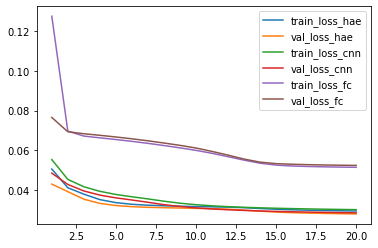

In [140]:
df_cnn = pd.DataFrame.from_dict(cnn_test, orient='index')
df_fc = pd.DataFrame.from_dict(fc_test, orient='index')
df_hae = pd.DataFrame.from_dict(hae_test, orient='index')
df_hae.join(df_cnn.join(df_fc, lsuffix = '_cnn', rsuffix='_fc')).rename({'train_loss': 'train_loss_hae', 'val_loss': 'val_loss_hae'}, axis=1).plot()
plt.show()

In [154]:
my_model_hae.encoder.parameters()

<generator object Module.parameters at 0x7f0a97b462e0>

In [187]:
sum([p.numel() for p in my_model_hae.encoder.lstm1.parameters()])

7104

In [178]:
sum([p.numel() for p in my_model_hae.encoder.fc1.parameters()])

55344

In [177]:
sum([p.numel() for p in my_model_cnn.encoder.fc1.parameters()])

27696

In [186]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ENCODER PARAMETERS\n-------------------------------------------------------------------------------")

print('CNN model params: {}, FC model params: {}'.format(count_parameters(my_model_cnn.encoder),
                                                        count_parameters(my_model_fc.encoder)))

print('HAE model params: {}'.format(count_parameters(my_model_hae.encoder)))

ENCODER PARAMETERS
-------------------------------------------------------------------------------
CNN model params: 35152, FC model params: 62424
HAE model params: 53840


#### Other testmy_model_hae

In [ ]:
my_model = SCSAE(latent_n = 48).to(DEVICE)
train_loop('MSE', 'constant', 1e-3, 'Adam', 0, 2000, my_model, '../../model_param/02cern.pt', DEVICE, my_dataloader)

In [ ]:
my_model = SCSAE(latent_n = 24).to(DEVICE)
train_loop('MSE', 'constant', 1e-3, 'Adam', 0, 2000, my_model, '../../model_param/03cern.pt', DEVICE, my_dataloader)

In [ ]:
my_model = SCSAE(latent_n = 12).to(DEVICE)
train_loop('MSE', 'constant', 1e-3, 'Adam', 0, 2000, my_model, '../../model_param/04cern.pt', DEVICE, my_dataloader)

BREAK

## Other Models

In [ ]:
my_dataset_fc = CERN_Dataset_CNN(train=True, mode = 'fc', fc_days = 12)
my_dataloader_fc = DataLoader(my_dataset_fc, batch_size = 128, shuffle = False)
my_dataset_val_fc = CERN_Dataset_CNN(train=False, mode = 'fc', fc_days = 12)
my_dataloader_val_fc = DataLoader(my_dataset_val_fc, batch_size = BATCH_SIZE, shuffle=False)

In [31]:
test_record = my_dataset_fc[0:2].numpy()

In [32]:
test_record.shape

(2, 576)

In [41]:
logging.basicConfig(filename='mylog.log',level=logging.DEBUG)

### KPCA

In [21]:
from sklearn.decomposition import KernelPCA

In [22]:
pca_dataset = my_dataset_fc.cern_data.cpu().numpy()

pca_dataset = pca_dataset.reshape(-1, 48)

In [23]:
pca_dataset.shape

(2481060, 48)

In [24]:
loss = nn.MSELoss()
total_losses = []
no_days = 12

for record_no in range(pca_dataset.shape[0] // (no_days)):
    pca = KernelPCA(4, kernel='rbf', fit_inverse_transform = True)
    current_record = pca_dataset[(record_no * no_days):((record_no + 1) * no_days), :]
    # print(current_record.shape)
    
    pca_test_compressed = pca.fit_transform(current_record)
    pca_test_uncompressed = pca.inverse_transform(pca_test_compressed)
    
    # print(pca_test_uncompressed.shape)
    
    total_losses.append(loss(torch.from_numpy(current_record), torch.from_numpy(pca_test_uncompressed)).item())

In [25]:
len(total_losses)

206755

In [26]:
sum(total_losses) / len(total_losses)

0.03398858254666112

### DCT

In [28]:
from scipy.fftpack import dct, idct, fft, ifft

In [33]:
compressed_dct = dct(test_record[0], type=2)

In [34]:
compressed_dct[48:] = 0

In [35]:
uncompressed_dct = idct(compressed_dct, type=2)

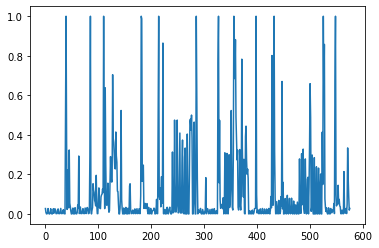

In [42]:
plt.plot(test_record[0])

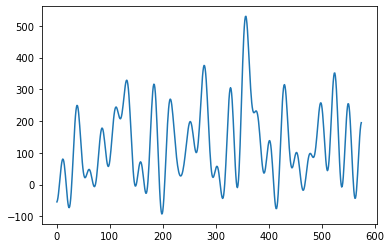

In [43]:
plt.plot(uncompressed_dct)

In [44]:
min_max_compressed = (uncompressed_dct - min(uncompressed_dct)) / (max(uncompressed_dct) - min(uncompressed_dct))

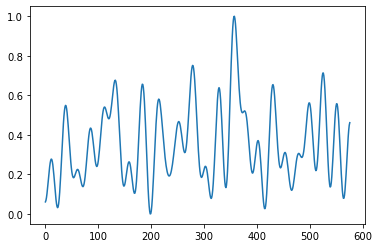

In [45]:
plt.plot(min_max_compressed)

In [46]:
loss(torch.from_numpy(test_record[0]), torch.from_numpy(min_max_compressed)).item()

0.09858974814414978

### FFT

In [47]:
compressed_fft = fft(test_record[0])

In [48]:
sum(compressed_fft)

(15.622059792280197+0j)

In [49]:
compressed_fft.shape

(576,)

In [50]:
compressed_fft[48:] = 0

In [51]:
uncompressed_fft = ifft(compressed_fft)

/scratch/au31/scotty/miniconda/conda/envs/jupyterlab/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


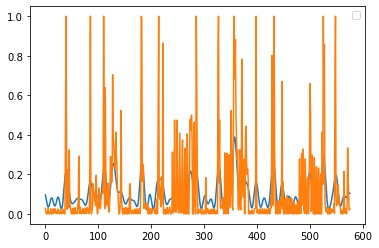

In [52]:
plt.plot(uncompressed_fft)
plt.plot(test_record[0])
plt.legend()

In [53]:
loss(torch.from_numpy(test_record[0]), torch.from_numpy(np.real(uncompressed_fft))).item()

0.030525270849466324

### SVD

In [54]:
k = 2
no_days = 12
all_losses = []

for record_no in range(pca_dataset.shape[0] // (no_days)):
    current_record = pca_dataset[(record_no * no_days):((record_no + 1) * no_days), :]
    
    u, s, v = np.linalg.svd(current_record)
    u_truncated = u[:, :k]
    s_truncated = s[:k]
    v_truncated = v[:k, :]
    
    smat = np.zeros((k, k), dtype=float)
    smat[:k, :k] = np.diag(s_truncated)
    
    reconstruction = np.dot(np.dot(u_truncated, smat), v_truncated)
    
    all_losses.append(loss(torch.from_numpy(current_record), torch.from_numpy(reconstruction)).item())

In [55]:
sum(all_losses) / len(all_losses)

0.02329762330539853

### DWT

In [59]:
!pip install pywt

ERROR: Could not find a version that satisfies the requirement pywt (from versions: none)
ERROR: No matching distribution found for pywt


In [60]:
import pywt

ModuleNotFoundError: No module named 'pywt'

In [ ]:
cA, cD = pywt.dwt(test_record[0], 'db2')
cA

In [ ]:
cD

### FLC

### SAX

In [56]:
# !pip install pyts

In [57]:
from scipy.stats import norm
from pyts.approximation import SymbolicAggregateApproximation

In [58]:
n_bins = 4